In [36]:
import torch
import numpy as np

In [49]:
x = torch.rand(5,3)
r = torch.rand(5, 3, requires_grad=True)
y = x.view(15)
z = x[0,0].item()
a = x.svd()
b = x.numpy()
s = x.add(r)

In [46]:
print(x.dtype)
print(y)
print(type(z))

### numpy to tensor
p = np.ones(5)
c = torch.from_numpy(p)

torch.float32
tensor([0.3900, 0.5928, 0.5010, 0.3445, 0.0489, 0.6430, 0.1102, 0.0478, 0.5851,
        0.4828, 0.2871, 0.1830, 0.6617, 0.9272, 0.1228])
<class 'float'>


In [55]:
print(s.grad_fn)
print(y.mean())
print(x.is_leaf, y.is_leaf, s.is_leaf)

tensor(0.4713)
True True False


In [56]:
# calc gradients
x = torch.ones(2, 2, requires_grad=True)
print(x, x.grad_fn)

y = x + 2
print(y, y.grad_fn)

z = y * 3
z.backward(torch.ones_like(z))
print(y.grad) # None
print(x.grad)

tensor([[1., 1.],
        [1., 1.]], requires_grad=True) None
tensor([[3., 3.],
        [3., 3.]], grad_fn=<AddBackward0>) <AddBackward0 object at 0x7fce367f5cd0>
None
tensor([[3., 3.],
        [3., 3.]])


我们构造一个简单的人工训练数据集，它可以使我们能够直观比较学到的参数和真实的模型参数的区别。设训练数据集样本数为1000，输入个数（特征数）为2。给定随机生成的批量样本特征$\boldsymbol{X} \in \mathbb{R}^{1000 \times 2}$，我们使用线性回归模型真实权重$w=[2, -3.4]^T$ ，和偏差b=4.2，以及一个随机噪声项$\epsilon$:
$\boldsymbol{y} = \boldsymbol{X}\boldsymbol{w} + b + \epsilon$

<class 'torch.Tensor'> torch.Size([1000, 2])
<class 'torch.Tensor'> torch.Size([1000])


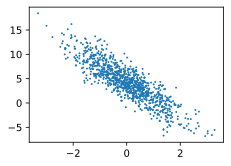

In [57]:
%matplotlib inline
import torch
from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import random

num_inputs = 2
num_examples = 1000
true_w = [2, -3.4]
true_b = 4.2
features = torch.from_numpy(np.random.normal(0, 1, (num_examples, num_inputs)))
print(type(features), features.shape)

labels = true_w[0] * features[:,0] + true_w[1] * features[:, 1] + true_b
print(type(labels), labels.shape)
labels += torch.from_numpy(np.random.normal(0, 0.01, size=labels.size())) # noise

def use_svg_display():
    display.set_matplotlib_formats('svg')

def set_figsize(figsize=(3.5, 2.5)):
    use_svg_display()
    plt.rcParams['figure.figsize'] = figsize

set_figsize()
plt.scatter(features[:, 1].numpy(), labels.numpy(), 1);


### read data
每次读取batch_size个样本.注意乱序读取.以使得每个batch的样本多样性足够丰富.



In [59]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        j = torch.LongTensor(indices[i: min(i + batch_size, num_examples)])
        yield features.index_select(0, j), labels.index_select(0,j)
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    pass

# init model param
w = torch.from_numpy(np.random.normal(0, 0.01, (num_inputs, 1)))
b = torch.zeros(1, dtype=torch.float64)
print(w.dtype, b.dtype)

w.requires_grad_(requires_grad=True)
b.requires_grad_(requires_grad=True)

# define model
def linreg(X, w, b):
    return torch.mm(X, w) + b

# define loss func
def squared_loss(y_hat, y):
    return (y_hat - y.view(y_hat.size())) ** 2 / 2

# define optimizer
def sgd(params, lr, batch_size):
    for param in params:
        param.data -= lr * param.grad / batch_size # attention! 这里改param时用的param.data


# train the model

lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss
batch_size = 10

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(linreg(X, w, b), y).sum()
        l.backward()
        sgd([w,b], lr, batch_size)

        w.grad.data.zero_()
        b.grad.data.zero_()
    train_l = loss(net(features, w, b), labels)
    print('epoch: ', epoch + 1, ', loss: ', train_l.mean().item())

print(true_w, '\n', w)
print(true_b, '\n', b)


torch.float64 torch.float64
epoch:  1 , loss:  0.03490234687512453
epoch:  2 , loss:  0.00012128088099764482
epoch:  3 , loss:  4.876614423234613e-05
[2, -3.4] 
 tensor([[ 1.9991],
        [-3.3996]], dtype=torch.float64, requires_grad=True)
4.2 
 tensor([4.1995], dtype=torch.float64, requires_grad=True)


In [60]:
# redefine the model using torch buitin modules
import torch.nn as nn

class LinearNet(nn.Module):
    def __init__(self, n_feature):
        super(LinearNet, self).__init__()
        self.linear = nn.Linear(n_feature, 1)
    
    def forward(self, x):
        y = self.linear(x)
        return y
net = LinearNet(num_inputs)
print(net)

LinearNet(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)


In [63]:
# define model using Sequential container
# method 1
net = nn.Sequential(
    nn.Linear(num_inputs, 1)
)

# method 2
net = nn.Sequential()
net.add_module('linear', nn.Linear(num_inputs, 1))
# net.add_module......

# method 3
from collections import OrderedDict
net = nn.Sequential(OrderedDict([
    ('linear', nn.Linear(num_inputs, 1))
]))
print(net)
print(net[0])

Sequential(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)
Linear(in_features=2, out_features=1, bias=True)


In [64]:
for param in net.parameters():
    print(param)

Parameter containing:
tensor([[-0.5692, -0.6541]], requires_grad=True)
Parameter containing:
tensor([0.6931], requires_grad=True)
